In [1]:
from util import fetch_minibatch
import numpy as np
import tensorflow as tf
from time import time
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
class Node(object):
    def __init__(self, sess, n_features, n_classes):
        self.sess = sess

        self.X_ = tf.placeholder(tf.float32, shape=[None, n_features])
        self.y_ = tf.placeholder(tf.float32, shape=[None, n_classes])
        self.w1 = tf.Variable(tf.random_uniform([n_features, n_classes]), name="w1")

        z1 = tf.matmul(self.X_, self.w1)
        probs = tf.nn.softmax(z1)

        self.loss = tf.losses.log_loss(labels=self.y_, predictions=probs)
        self.op = tf.train.AdamOptimizer(0.01).minimize(self.loss)
        
        self.grad = tf.gradients(self.loss, self.w1)
        
        predictions = tf.argmax(probs, 1)
        correct_prediction = tf.equal(predictions, tf.argmax(self.y_, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
    def fetch_grad(self, w, X, y):
        """
        given weight w_i and data {X_i, y_i}, compute gradient.
        """
        self.w1.load(w, self.sess)
        return self.sess.run(self.grad, feed_dict={self.X_:X, self.y_:y})[0]
        
    def fit(self, X, y, epochs):
        for epoch in range(epochs):
            _ = self.sess.run(self.op, feed_dict={self.X_:X, self.y_:y})
            
    def score(self, X, y):
        return self.sess.run(self.accuracy, feed_dict={self.X_:X, self.y_:y})

    def fetch_weights(self):
        return self.sess.run(self.w1)
    
    def load(self, w):
        self.w1.load(w, self.sess)

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
from sklearn import datasets
iris = datasets.load_iris()
X_full = iris.data
y_full = np.eye(3)[iris.target]
n_features = X_full[0].shape[0]
n_classes = y_full[0].shape[0]

In [5]:
server_batch_size = 30

X_test, y_test = fetch_minibatch(X_full, y_full, server_batch_size)

with tf.Session() as sess:    
    Master = Node(sess, n_features, n_classes)
    sess.run(tf.global_variables_initializer())
        
    print("untrained accuracy: ", Master.score(X_full, y_full))
    
    n_epochs = 20
    X_server, y_server = fetch_minibatch(X_full, y_full, server_batch_size)
    Master.fit(X_server, y_server, n_epochs)
    
    print("accuracy, using updated weights {0:.3f} ".format(Master.score(X_full, y_full)))
    
    server_w1 = Master.fetch_weights()

untrained accuracy:  0.33333334
accuracy, using updated weights 0.773 


In [6]:
original_server_w1 = server_w1

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
round 0 execution time: 1.4655373096466064 accuracy: 0.8533333539962769
round 1 execution time: 1.7329182624816895 accuracy: 0.9599999785423279
round 2 execution time: 1.8065688610076904 accuracy: 0.9599999785423279
round 3 execution time: 1.2763216495513916 accuracy: 0.9666666388511658
round 4 execution time: 1.301342248916626 accuracy: 0.9666666388511658
round 5 execution time: 1.4686737060546875 accuracy: 0.9666666388511658
round 6 execution time: 1.4344935417175293 accuracy: 0.9666666388511658
round 7 execution time: 1.5069093704223633 accuracy: 0.95333331823349
round 8 execution time: 1.5640652179718018 accuracy: 0.9666666388511658
round 9 execution time: 1.4668967723846436 accuracy: 0.9599999785423279
completed


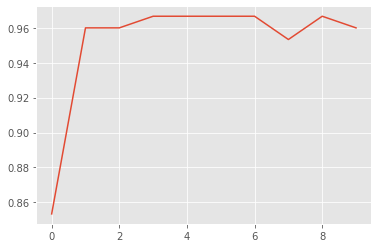

In [7]:
learning_rate = .1
n_epochs = 500
n_clients = 5
client_batch_size = 5
n_rounds = 10
ls_accuracy = []

with tf.Session() as sess:
    Worker = Node(sess, n_features, n_classes)
    sess.run(tf.global_variables_initializer())
    
    for r in range(n_rounds):
        s = time()
        
        # each round needs a new average client weights
        ls_client_w1 = []
        
        for client in range(n_clients):

            # each client receives the same server weight
            client_w1 = server_w1

            # each client has their own minibatch
            X_client, y_client = fetch_minibatch(X_full, y_full, client_batch_size)
            
            # calculate term b gradient using (1) server weights and (2) client data
            term_b = Worker.fetch_grad(server_w1, X_client, y_client)
            
            # compute term c gradient using (1) server weights and (2) server data
            term_c = Worker.fetch_grad(server_w1, X_server, y_server)

            # client parameter updates
            for n in range(n_epochs):
                # compute term a gradient using (1) client weights and (2) client data
                term_a = Worker.fetch_grad(client_w1, X_client, y_client)

                # update client weights
                client_w1 = client_w1 - learning_rate * (term_a - term_b + term_c)

            # track weights for each client
            ls_client_w1.append(client_w1)
        
        # after all clients are accounted for, update server weights each round
        server_w1 = np.mean(ls_client_w1, axis=0)
        Worker.load(server_w1)
        acc = Worker.score(X_full, y_full)
        print("round {} execution time: {} accuracy: {}".format(r, time() - s, acc))
        ls_accuracy.append(acc)
    
print("completed")
plt.plot(ls_accuracy)

In [11]:
with tf.Session() as sess:    
    Master = Node(sess, n_features, n_classes)
    sess.run(tf.global_variables_initializer())
    
    Master.load(original_server_w1)
    print("untrained accuracy: ", Master.score(X_test, y_test))
    Master.load(server_w1)  # use average weights from clients
    print("accuracy, using updated weights: ", Master.score(X_test, y_test))

untrained accuracy:  0.8333333
accuracy, using updated weights:  1.0
